In [88]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [89]:
# Read the CSV file
df = pd.read_csv('Resources/global-data-on-sustainable-energy (1).csv')

In [90]:
df.dtypes

Entity                                                               object
Year                                                                  int64
Access to electricity (% of population)                             float64
Access to clean fuels for cooking                                   float64
Renewable-electricity-generating-capacity-per-capita                float64
Financial flows to developing countries (US $)                      float64
Renewable energy share in the total final energy consumption (%)    float64
Electricity from fossil fuels (TWh)                                 float64
Electricity from nuclear (TWh)                                      float64
Electricity from renewables (TWh)                                   float64
Low-carbon electricity (% electricity)                              float64
Primary energy consumption per capita (kWh/person)                  float64
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         float64
Value_co2_em

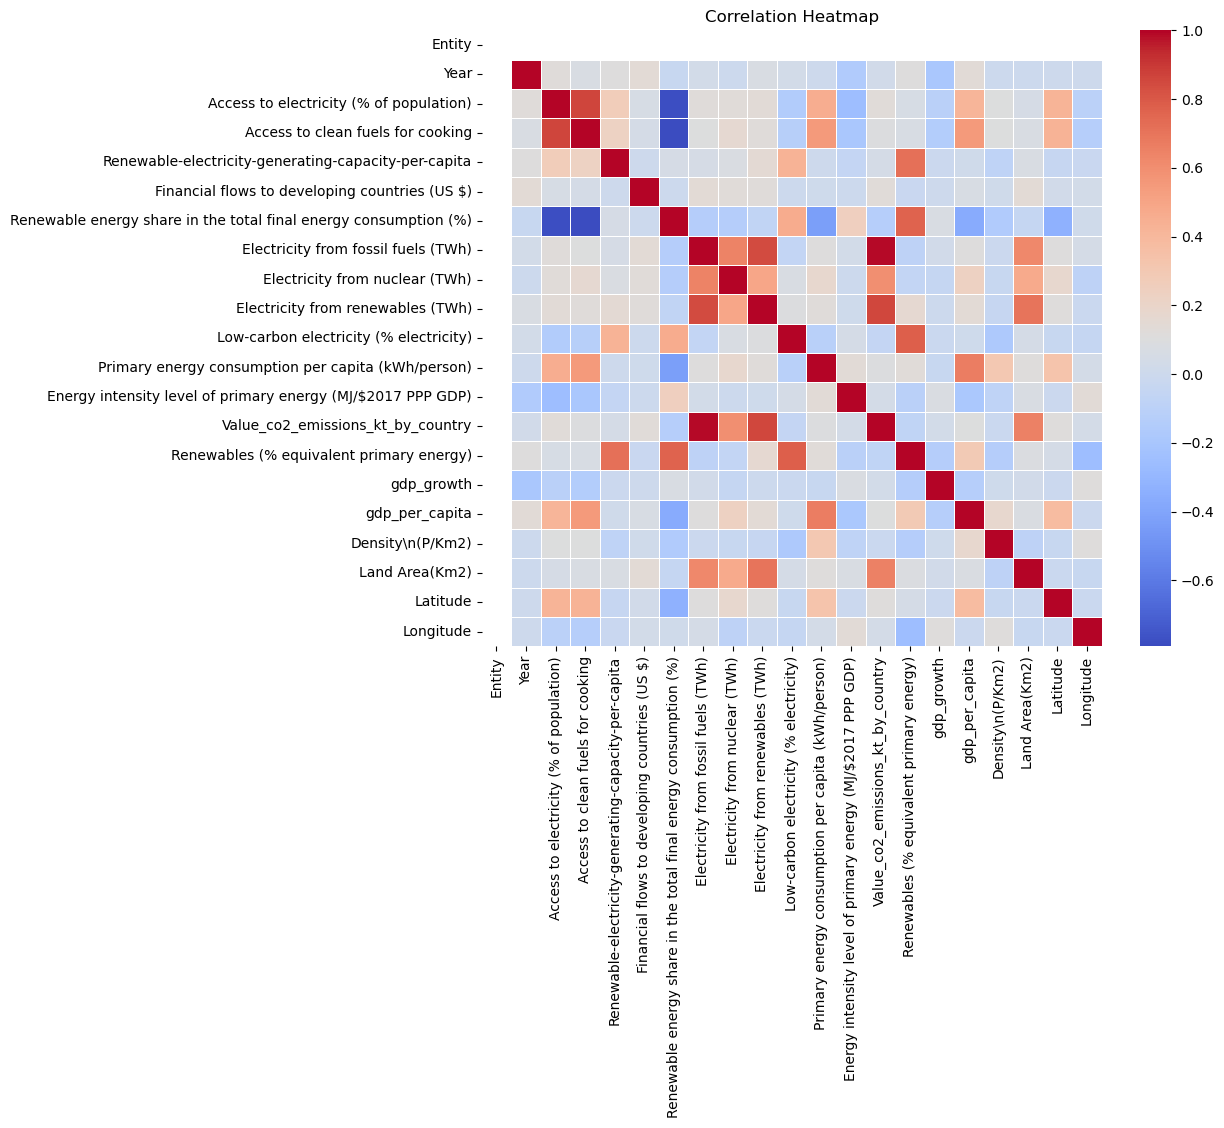

In [91]:
# Function to clean and convert to float
def clean_and_convert(value):
    try:
        # Clean the string by removing commas and other non-numeric characters
        cleaned_value = ''.join(filter(str.isdigit, str(value)))
        
        # Convert the cleaned string to a float
        return float(cleaned_value)
    except ValueError:
        # Handle conversion errors by returning NaN
        return float('nan')
        # Function to clean and convert to float

# Apply the clean_and_convert function to the column
df['Land Area(Km2)'] = df['Land Area(Km2)'].apply(clean_and_convert)

# Apply the clean_and_convert function to the 'Entity' column
df['Entity'] = df['Entity'].apply(clean_and_convert)

# Find a similar column name
target_column_name = None
for column in df.columns:
    if 'Density' in column and 'Km2' in column:
        target_column_name = column
        break

if target_column_name:
    # Function to clean and convert to float
    def clean_and_convert(value):
        try:
            # Remove commas and other non-numeric characters, then convert to float
            cleaned_value = float(''.join(filter(str.isdigit, str(value))))
            return cleaned_value
        except ValueError:
            # Handle conversion errors by returning NaN
            return float('nan')

    # Clean and convert the target column
    df[target_column_name] = df[target_column_name].apply(clean_and_convert)

    # Correlation heatmap
    correlation_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No similar column name found.")

In [92]:
## DECISION TREE  ####
# Merge the datasets
df_2020 = pd.read_csv('Resources/global-data-on-sustainable-energy (1).csv')
df2 = pd.read_csv('Resources/ETI_2020.csv')
merged_df = pd.merge(df_2020, df2, on='Entity', how='inner')

# Define features set
X = merged_df.copy()
X.drop("ETI 2020 ranking", axis=1, inplace=True)

# Define target vector
y = merged_df["ETI 2020 ranking"]

# Check for missing values in y
missing_values = y.isnull().sum()

#  missing values, 
if missing_values > 0:
    merged_df.dropna(subset=["ETI 2020 ranking"], inplace=True)
    X = merged_df.copy()
    y = merged_df["ETI 2020 ranking"]

# Handle missing values by imputing with the mean value for numeric columns
X.fillna(X.mean(), inplace=True)

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to non-numeric columns
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

C:\Users\Kirsty Armstrong\AppData\Local\Temp\ipykernel_5528\732627688.py:24: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X.fillna(X.mean(), inplace=True)


In [93]:
# Split the data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

# Initialize and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)

X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Make predictions
predictions = model.predict(X_test_scaled)

In [94]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculate the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Display the results
print("Confusion Matrix:")
print(cm)
print("\nAccuracy Score:", acc_score)

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]

Accuracy Score: 0.9723502304147466


In [95]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5, 9]
}

# Create the GridSearchCV object with the DecisionTreeClassifier and parameter grid
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=78),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available CPU cores
                           verbose=2)  # Provide verbosity

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator (model) found by GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions using the best model
best_predictions = best_model.predict(X_test_scaled)

# Calculate the confusion matrix for the best model
best_cm = confusion_matrix(y_test, best_predictions)

# Calculate the accuracy score for the best model
best_acc_score = accuracy_score(y_test, best_predictions)

# Display the results for the best model
print("Best Model Confusion Matrix:")
print(best_cm)
print("\nBest Model Accuracy Score:", best_acc_score)
plt.show()


Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Model Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]

Best Model Accuracy Score: 0.9838709677419355


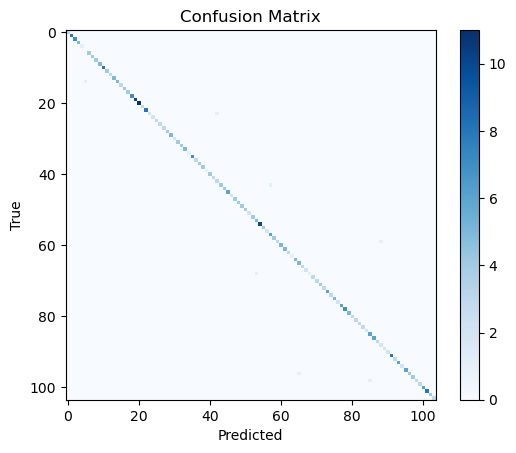

In [96]:
# predictions and true labels
cm = confusion_matrix(y_test, best_predictions)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [97]:
print(classification_report(y_test, best_predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         8
         3.0       1.00      1.00      1.00         7
         4.0       1.00      1.00      1.00         5
         5.0       1.00      1.00      1.00         1
         6.0       0.00      0.00      0.00         0
         7.0       1.00      1.00      1.00         4
         8.0       1.00      1.00      1.00         4
         9.0       1.00      1.00      1.00         4
        10.0       1.00      1.00      1.00         5
        11.0       1.00      1.00      1.00         8
        12.0       1.00      1.00      1.00         4
        13.0       1.00      1.00      1.00         3
        14.0       1.00      1.00      1.00         5
        16.0       1.00      0.83      0.91         6
        17.0       1.00      1.00      1.00         3
        18.0       1.00      1.00      1.00         4
        19.0       1.00    

c:\Users\Kirsty Armstrong\anaconda3\envs\dev2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kirsty Armstrong\anaconda3\envs\dev2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kirsty Armstrong\anaconda3\envs\dev2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



(process:32196): GLib-GIO-WARNING **: 16:10:52.763: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2305.26.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:32196): GLib-GIO-WARNING **: 16:10:52.799: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.7.9.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs



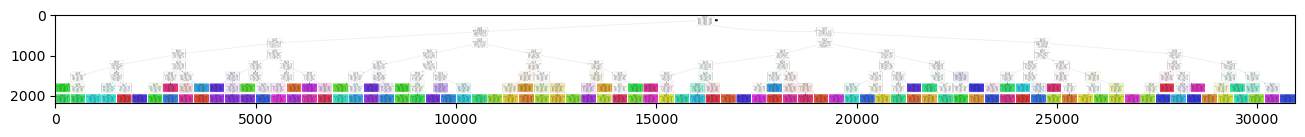

In [98]:
from graphviz import Digraph
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.tree import export_graphviz
# Create dot data
dot_data = export_graphviz(
                best_model,
                out_file=None,
                rounded=True,
                filled=True
            )
# Write to PNG
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree_model.png')
# Show as pyplot figure
plt.figure(figsize=(16,20))
imgplot = plt.imshow(mpimg.imread('tree_model.png'))
plt.show()